In [1]:
# importing tools 
import s3fs
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt 
#for removing warnings
import warnings

In [2]:
# open the data with s3fs from the databucket 
fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
data_path1 = 's3://data/CREG12.L75-REF08_mesh_zgr.zarr'
data_path2 = 's3://data/vel_dataIII.zarr/vel_dataIII.zarr'
data_path3 = 's3://data/lat_lon_scalar.zarr'

remote_files1 = fsg.glob(data_path1)
remote_files2 = fsg.glob(data_path2)
remote_files3 = fsg.glob(data_path3)

store1 = s3fs.S3Map(root=data_path1, s3=fsg, check=False)
store2 = s3fs.S3Map(root=data_path2, s3=fsg, check=False)
store3 = s3fs.S3Map(root=data_path3, s3=fsg, check=False)

dzz = xr.open_zarr(store=store1, consolidated=True)
dv = xr.open_zarr(store=store2, consolidated=True)
dl = xr.open_zarr(store=store3, consolidated=True)

In [3]:
bathym = dzz.mbathy.isel(x=slice(200,1400),y=slice(650,1800))

In [4]:
lat = dzz.nav_lat.isel(x=slice(200,1400),y=slice(650,1800))
lon = dzz.nav_lon.isel(x=slice(200,1400),y=slice(650,1800))
lon_flat = dzz.nav_lon.isel(x=slice(200,1400),y=slice(650,1800)).values.flatten()
lat_flat = dzz.nav_lat.isel(x=slice(200,1400),y=slice(650,1800)).values.flatten()

# Prøver å finne y,x index for mooringene 

In [5]:
p_list = [(31.13247,81.24202),(31.13533,81.24255),(31.14506,81.24587)
          ,(011.1189, 69.5289),(013.16845,68.58759),(013.19866,68.56109),(012.45082,68.50128)
          ,(5.57541,79.37209),(5.48733,80.03876),(5.56333,79.44093)
          ,(-152.04848,71.39398),(-152.04848,71.39398),(-152.05077,71.39432),(-152.05066,71.39435)]

In [6]:
'Updated p_list, adding chukchi sea moorings'
 #[(31.13247,81.24202),(31.13533,81.24255),(31.14506,81.24587)
          #,(011.1189, 69.5289),(013.16845,68.58759),(013.19866,68.56109),(012.45082,68.50128)
          #,(5.57541,79.37209),(5.48733,80.03876),(5.56333,79.44093)
          #,(-152.04848,71.39398),(-152.04848,71.39398),(-152.05077,71.39432),(-152.05066,71.39435)
p_list = [(-160.4923,72.121),(-159.1216,72.1628),(-158.5512,72.1815),(-163.5346,72.2808),(-164.0992,72.5252)]

In [50]:
print(f'punkter jeg er ferdig med er :{p_list[3]}, neste punkter er {p_list[4]}')
p = p_list[4]

punkter jeg er ferdig med er :(-163.5346, 72.2808), neste punkter er (-164.0992, 72.5252)


In [51]:
# Trying to find the closest latitude value and longitude value in the model to the moorings lat lon 
lat_value = [min(lat_flat, key=lambda x:abs(x-h)) for h in [p[1]]]
lon_value = [min(lon_flat, key=lambda x:abs(x-h)) for h in [p[0]]]
print('lat value closest to point ', p[1],'is ', lat_value)
print('lon value closest to point ', p[0],'is ', lon_value)

lat value closest to point  72.5252 is  [72.52518]
lon value closest to point  -164.0992 is  [-164.09886]


In [52]:
# Trying to find the x,y index to lat,lon value in the model 
idx_lat = np.where(lat.values==lat_value)
idx_lon = np.where(lon.values==lon_value)
print('index for lat :', idx_lat)
print('index for lon :', idx_lon)
print('---------------------------')
print('lat values: ', lat[idx_lat].values)
print('lon values with lat idx: ', lon[idx_lat].values)
print('---------------------------')
print('lon values: ', lon[idx_lon].values)
print('lat values with lon idx: ', lat[idx_lon].values)
print('-----------------------------')

index for lat : (array([230, 960]), array([362, 362]))
index for lon : (array([1040]), array([419]))
---------------------------
lat values:  [[72.52518 72.52518]
 [72.52518 72.52518]]
lon values with lat idx:  [[ -60.34387  -60.34387]
 [-153.65613 -153.65613]]
---------------------------
lon values:  [[-164.09886]]
lat values with lon idx:  [[70.37078]]
-----------------------------


Because the closest latitude and longitude found by the methode above gave different index for lat lon, the closest latitude/longentude to the point found are porbably at different locations. Take also the abs, so could even be negative side, since the lon goes from -180,180...

Need to find the longitude line where I think the closest latitude is for so to vertify myself:

- Assumes that the grid is shaped 'round', so to find closest lat,lon to moorigspoint I need to first find the longitude line closest to mooring longitude, for so on that line find the closest latitude point myself.

In [53]:
idx_l = []
diff_lon = []
lon_l = []
for i,item in enumerate(lon_flat):
    d = item - p[0]
    if abs(d)<0.5:
        idx_l.append(i) 
        diff_lon.append(d) 
        lon_l.append(item)

In [54]:
diff_lonlat = []
diff_lat = []
idx_lat = []
for i in idx_l:
    d = lat_flat[i]-p[1]
    if abs(d)<0.5:
        diff_lonlat.append(d)
        diff_lat.append(lat_flat[i])
        idx_lat.append(i)

In [57]:
print(p[1])
print(p[0])
print(diff_lat[101])
print(idx_lat[101])
print(lat_flat[idx_lat[90:110]])
print(lon_flat[idx_lat[90:110]])
print(np.where(lat.values==lat_flat[idx_lat[101]]))
i_lat = np.where(lat.values==lat_flat[idx_lat[101]])

72.5252
-164.0992
72.522545
1192040
[72.52179  72.53528  72.54872  72.56211  72.57546  72.44169  72.455284
 72.46884  72.482346 72.4958   72.50919  72.522545 72.53586  72.388725
 72.40233  72.415886 72.4294   72.442856 72.45627  72.469635]
[-164.00366 -164.12283 -164.24219 -164.36172 -164.48145 -163.69717
 -163.81564 -163.93431 -164.05315 -164.17218 -164.2914  -164.41081
 -164.5304  -163.62862 -163.74678 -163.86513 -163.98366 -164.10239
 -164.22128 -164.34036]
(array([993]), array([440]))


In [56]:
print(p[1])
diff_lat[100:110]

72.5252


[72.50919,
 72.522545,
 72.53586,
 72.388725,
 72.40233,
 72.415886,
 72.4294,
 72.442856,
 72.45627,
 72.469635]

In [14]:
#idx_moor = []

In [59]:
idx_moor.append((i_lat[1][0],i_lat[0][0]))

In [60]:
idx_moor

[(409, 992), (399, 987), (395, 985), (434, 997), (440, 993)]

IndexError: index 1 is out of bounds for axis 0 with size 1

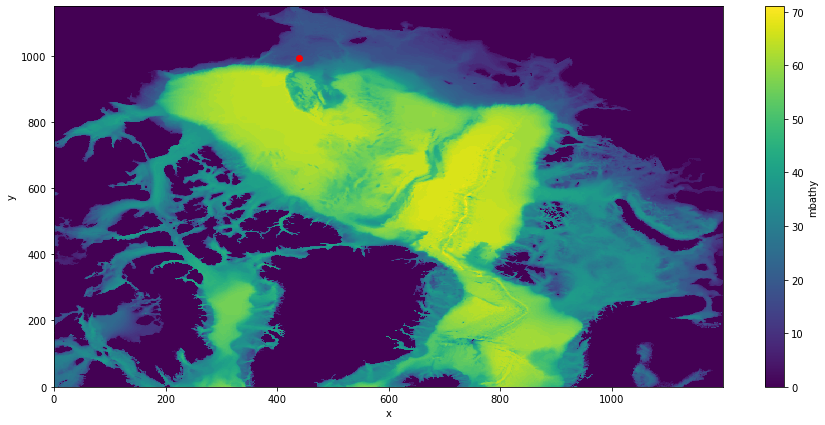

In [58]:
fig, ax = plt.subplots(figsize=(15,7))
bathym.plot()
ax.plot(i_lat[1][0],i_lat[0][0], marker='o', color='r')
ax.plot(i_lat[1][1],i_lat[0][1], marker='o', color='orange')
#ax.plot(idx_moor[0][0],idx_moor[0][1], marker='o', color='g')


'not sure whether np.where give x or y first.....'
#ax.plot(idx_lat[0][0],idx_lat[0][1], marker='o', color='y')
#ax.plot(idx_lat[1][0],idx_lat[1][1], marker='o', color='pink')

#ax.plot(idx_lon[1][0],idx_lon[0][0], marker='o', color='orange')
ax.set_aspect('equal')

In [38]:
print('OK, funker for p_list[0], må sjekke for de andre også!')

OK, funker for p_list[0], må sjekke for de andre også!
